1 March family creator 
2 "Yippee!" alternative 
3 Ferret's cousin 
4 Humorous internet image 
5 Full of dryer fluff 
6 Photographed or taped 
7 Ina quandary 
8 It might produce a run 
9 Former nuclear power agcy.
10 Flared dress style 
11 Shoes, sandals, sneakers, etc.
12 Director Howard 
13 Photo _ (media events) 
18 Plastic __ Band 
19 More moth-eaten, e.g. 
24 Historic Alabama city 
25 Challenge to a canoer 
26 Bambi's mother, e.g.
28 Bit of Halloween attire
30 Musical with its own glasses?
31 "The __ of Pooh" 
34 Concentrate, in a way
35 Group of eight
37 It's used to take flight?
38 When doubled, a Society Island
39 Campus VIP
40 Gangster's gun in old films
41 Sleep phenomenon
45 "The Twilight Zone" telecasts, today
47 Baltimore's bird
48 Body shop convenience
49 Has a hunch
51 One way to get out of debt
53 Metal-shaping tool
54 Place for an orchestra
57 Take out, to an editor
58 Lung opening?
59 Approaching, in romantic poetry
60 "Do the Right Thing" pizzeria owner
61 Common sav

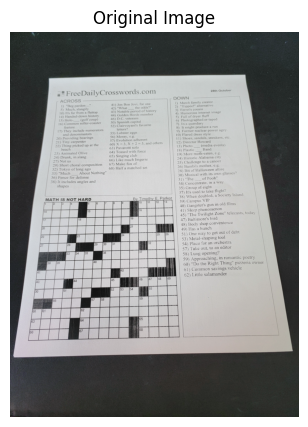

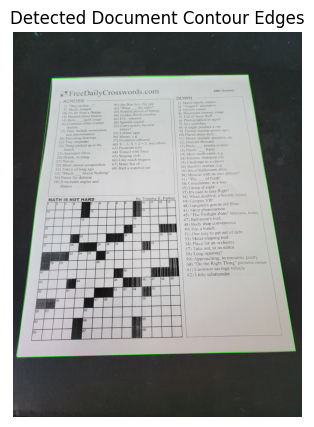

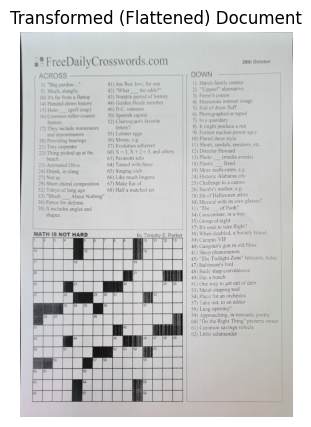

In [307]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pytesseract
import re


# Currently works for image E 
def show_img(img, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off') 

#Set the URL of the server
url = "http://127.0.0.1:5000/"  # Make sure this matches your Flask app's URL

#Path to the image file on your local disk
image_path = "crosswordE.jpg"


#Load the original image using OpenCV (to display it)
orig = cv2.imread(image_path)

#Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig)
plt.axis('off')  # Hide axes

def extract_boxes(image):
    # Load the image
    height, width = image.shape[:2]

    # Define the regions based on the layout
    # Box 1: Left half of the page
    across1 = image[(height*12//100):(height//2), (width//18):(width*8//25)]
    across2 = image[(height*12//100):(height//2), (width*9//30):(width*3//5)]
    # Box 2: Right half of the page
    down = image[(height*12//100):(height-(height*12//100)), ((width*40)//65):(width-(width//19))]

    # Box 3: Right side, top third width
    cross = image[(height//2)+(height//30):(height-(height//25)), ((width//22)):(width*3//5)]
    
    cv2.imwrite("across1.png", across1)
    cv2.imwrite("across2.png", across2)
    cv2.imwrite("down.png", down)
    cv2.imwrite("cross.png", cross)   

    return across1, across2, down, cross


def process(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, sharpening_kernel)

    mask = cv2.inRange(image, 0, 180)
    image[mask == 255] = 0     

    near_white_mask = cv2.inRange(image, 190, 255)
    image[near_white_mask == 255] = 255

    cv2.imwrite("process.png", image) 

    return image

def text_extract(image):
    process(image)
    custom_config = r'--oem 1 --psm 6'
    # Use pytesseract to extract text from the image
    extracted_text = pytesseract.image_to_string(image, config=custom_config)
    #print(extracted_text)
    extracted_text = extracted_text.replace("$", "5")
    extracted_text = extracted_text.replace("|", "1") 
    # Split the text into individual lines
    lines = extracted_text.split("\n")

    # Initialize an array with 71 slots (0 to 70) since the max index is 70
    clue_array = [""] * 71

    current_index = None  # Track the current index for multi-line clues

    # Process each line
    for line in lines:
        if ")" in line:
            # Try to split at the first closing parenthesis
            parts = line.split(")", 1)
            try:
                # Check if the first part is an integer (indicating a new clue)
                index = int(parts[0].strip())
                clue_text = parts[1].strip()
                
                # Start a new clue at the specified index
                clue_array[index] = clue_text
                current_index = index  # Update the current index for possible multi-line clue

            except ValueError:
                # If conversion fails, treat it as part of the previous clue
                if current_index is not None:
                    # Append this line to the current clue
                    clue_array[current_index] += " " + line.strip()
        else:
            # Treat lines without an index as continuation of the previous clue
            if current_index is not None:
                clue_array[current_index] += " " + line.strip()

    # Print each index and its clue, skipping empty entries
    # for i in range(len(clue_array)):
    #     if clue_array[i]:  # Only print non-empty clues
    #         print(i, clue_array[i])

    return clue_array


def remove_grid_lines(image):
    """Remove grid lines using morphological operations."""
    kernel = np.ones((15, 15), np.uint8)  # Larger kernel to cover the grid lines
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closed_image

def find_contours(edges):
    """Find contours and select the one with 4 corners that represents the document."""
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter out smaller contours based on area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    valid_contours = []
    
    for contour in contours:
        # Get contour area
        area = cv2.contourArea(contour)
        
        # Filter out small contours (likely to be the grid squares)
        if area > 5000:  # Threshold the area to remove small contours (adjust as needed)
            epsilon = 0.05 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if len(approx) == 4:
                valid_contours.append(approx)
    
    # If valid contours exist, return the largest one (which should be the document)
    if valid_contours:
        valid_contours = sorted(valid_contours, key=cv2.contourArea, reverse=True)
        return valid_contours[0].reshape(4, 2)
    
    return None  # No valid contours found

def preprocess(): 
    """
    Applies steps to make an image ready for crossword solving:
    
    1. Converts the original image to grayscale.
    2. Applies Gaussian blur to reduce noise.
    3. Uses bilateral filtering to further smooth the image while preserving edges.
    4. Enhances contrast with binary thresholding.
    5. Performs edge detection using the Canny algorithm.
    6. Finds contours in an image to find the 4 corners representing the document. 
    
    Each intermediate image is displayed with a descriptive title.
    """
    # Grayscale 
    grayscale = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite("grayscale_image.jpg", grayscale)
    #show_img(grayscale, "grayscale")

    # Gaussian Blur 
    gauss = cv2.GaussianBlur(grayscale, (5,5), 0)
    #cv2.imwrite("blur.jpg", gauss)
    #show_img(gauss, "gauss")

    # Bilateral Filtering
    bilat = cv2.bilateralFilter(gauss,9,75,75)
    #cv2.imwrite("bilat.jpg", bilat)
    #show_img(bilat, "bilat")
    
    # Contrast 
    _, thresh = cv2.threshold(bilat, 128, 255, cv2.THRESH_BINARY)
    #cv2.imwrite("thresh.jpg", thresh)
    #show_img(thresh, "thresh")

    clean = remove_grid_lines(thresh)
    #show_img(clean,"c")
    # Edge Detection 
    edges = cv2.Canny(clean, 100, 150)
    #cv2.imwrite("canny.jpg", canny)
    #show_img(edges, "edges")

    # Contours 
    corners = find_contours(edges)

    if corners is None:
        print("No contour with 4 corners found.")
        return jsonify({"error": "Document edges not detected"}), 400

    contours = orig.copy()
    cv2.drawContours(contours, [corners], -1, (0, 255, 0), 3)
    show_img(contours, "Detected Document Contour Edges")

    # top left, top right, bottom left, bottom right
    dst_points = np.float32([[2480, 0], [0, 0], [0, 3508], [2480, 3508]])
    matrix = cv2.getPerspectiveTransform(np.float32(corners), dst_points)
    transformed = cv2.warpPerspective(orig, matrix, (2480, 3500))
    show_img(transformed, "Transformed (Flattened) Document")
    return transformed


def crossword_extract(image):
    # Process the image (ensure you define the 'process' function for preprocessing)
    image = process(image)  # You should define this function
    
    # Find contours of grid cells
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Prepare to display the contours (optional, for debugging)
    contour_image = image.copy()
    show_img(image, "og.jpg")
    show_img(cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2),"meow.jpg")
    
    # Initialize the grid as an empty list
    grid = []
    
    # Initialize an empty grid (adjust rows and cols based on the size of your crossword grid)
    rows, cols = 15, 15  # Example: Assume 15x15 grid for now
    grid = [['.' for _ in range(cols)] for _ in range(rows)]  # Fill with placeholders
    
    # Loop through the contours and detect the grid cells
    for contour in contours:
        # Get the bounding box of each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Set a threshold for cell size to avoid noise (this depends on the grid's size in the image)
        if w > 10 and h > 10:
            # Extract the grid square from the image
            cell_image = image[y:y+h, x:x+w]
            
            # Check if the cell is black (blacked-out square)
            if np.mean(cell_image) < 100:  # Dark color indicates blacked-out square
                row = (y + h // 2) // (image.shape[0] // rows)  # Calculate row based on vertical position
                col = (x + w // 2) // (image.shape[1] // cols)  # Calculate col based on horizontal position
                grid[row][col] = '#'  # Add black square to the grid
            else:
                # Check for clue numbers using OCR (Tesseract)
                text = pytesseract.image_to_string(cell_image, config='--psm 6')
                
                # If the detected text is a number, it's a clue number
                if text.strip().isdigit():
                    row = (y + h // 2) // (image.shape[0] // rows)
                    col = (x + w // 2) // (image.shape[1] // cols)
                    grid[row][col] = int(text.strip())  # Add the clue number to the grid
    
    # Return the final grid as a 2D array
    return grid

img = preprocess()
across1, across2, down, cross = extract_boxes(img)
# arr2 = text_extract(across2)
# arr1 = text_extract(across1)
arr1 = text_extract(down)
crossword_extract(cross)


# for i in range(len(arr1)):
#     if not arr1[i] and arr2[i]:
#         arr1[i] = arr2[i]

for i in range(len(arr1)):
    if arr1[i]:
        print(i, arr1[i])

#text_extract(down)
#across_clues, down_clues, crossword_grid = crossword_extract(img)
#print(across_clues, down_clues, crossword_grid)


#Open the image file in binary mode and send the POST request
with open(image_path, "rb") as image_file:
    files = {"image": image_file}
    res = requests.post(url, files=files)

#Check the response
print(res.status_code)
print(res.text)  # Assuming the response is in JSON format

In [ ]:
def show_img(img, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off') 

#Set the URL of the server
url = "http://127.0.0.1:5000/"  # Make sure this matches your Flask app's URL

#Path to the image file on your local disk
image_path = "crosswordC.jpg"

#Load the original image using OpenCV (to display it)
orig = cv2.imread(image_path)

#Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig)
plt.axis('off')  # Hide axes

def find_contours(edges):
    """Find contours and select the one with 4 corners that represents the document."""

    # cv2.RETR_EXTERNAL retrieves only the outer contours
    # cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments, leaving only their endpoints.
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  # Found a quadrilateral
            print(f"Found a quadrilateral (paper) contour: {approx}")
            return approx.reshape(4, 2)  # Return the 4 corner points

    return None  # No suitable contour found

def preprocess(): 
    """
    Applies steps to make an image ready for crossword solving:
    
    1. Converts the original image to grayscale.
    2. Applies Gaussian blur to reduce noise.
    3. Uses bilateral filtering to further smooth the image while preserving edges.
    4. Enhances contrast with binary thresholding.
    5. Performs edge detection using the Canny algorithm.
    6. Finds contours in an image to find the 4 corners representing the document. 
    
    Each intermediate image is displayed with a descriptive title.
    """
    # Grayscale 
    grayscale = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite("grayscale_image.jpg", grayscale)
    show_img(grayscale, "grayscale")

    # Gaussian Blur 
    gauss = cv2.GaussianBlur(grayscale, (5,5), 0)
    #cv2.imwrite("blur.jpg", gauss)
    show_img(gauss, "gauss")

    # Bilateral Filtering
    bilat = cv2.bilateralFilter(gauss,9,75,75)
    #cv2.imwrite("bilat.jpg", bilat)
    show_img(bilat, "bilat")
    
    # Contrast 
    #thresh = cv2.adaptiveThreshold(bilat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5)
    _, thresh = cv2.threshold(bilat, 190, 255, cv2.THRESH_BINARY)
    #cv2.imwrite("thresh.jpg", thresh)
    show_img(thresh, "thresh")

    # Edge Detection 
    edges = cv2.Canny(thresh, 50, 150)
    #cv2.imwrite("canny.jpg", canny)
    show_img(edges, "edges")

    # Contours 
    corners = find_contours(edges)

    if corners is None:
        print("No contour with 4 corners found.")
        return jsonify({"error": "Document edges not detected"}), 400

    contours = orig.copy()
    cv2.drawContours(contours, [corners], -1, (0, 255, 0), 3)
    show_img(contours, "Detected Document Contour Edges")

    dst_points = np.float32([[2480, 0], [0, 0], [0, 3508], [2480, 3508]])  # A4 paper size
    matrix = cv2.getPerspectiveTransform(np.float32(corners), dst_points)
    transformed = cv2.warpPerspective(orig, matrix, (2480, 3500))
    show_img(transformed, "Transformed (Flattened) Document")

preprocess()

#Open the image file in binary mode and send the POST request
with open(image_path, "rb") as image_file:
    files = {"image": image_file}
    res = requests.post(url, files=files)

#Check the response
print(res.status_code)
print(res.text)  # Assuming the response is in JSON format

In [271]:

import requests
import matplotlib.pyplot as plt
import numpy as np
import io

#Set the URL of the server
url = "http://127.0.0.1:5000/"

#Path to the image file on your local disk
image_path = "crossword1.jpg"  # Change as needed

#Open the image file in binary mode
with open(image_path, "rb") as image_file:
    # Prepare the files parameter with the image file
    files = {"image": image_file}

#Send the POST request with body and files
    res = requests.post(url, files=files)

#Check the response
if res.status_code == 200:
    response_data = res.json()
    original_image_hex = response_data['orig']
    transformed_image_hex = response_data['transformed_image']

    # Convert hex to bytes
    original_image_bytes = bytes.fromhex(original_image_hex)
    transformed_image_bytes = bytes.fromhex(transformed_image_hex)

    # Display original image
    original_image = plt.imread(io.BytesIO(original_image_bytes), format='png')
    plt.subplot(121), plt.imshow(original_image)
    plt.title('Detected Corners')

#Display transformed image
    transformed_image = plt.imread(io.BytesIO(transformed_image_bytes), format='png')
    plt.subplot(122), plt.imshow(transformed_image)
    plt.title('Transformed (Flattened) Crossword')

    plt.show()
else:
    print(f"Error: {res.status_code} - {res.text}")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
import requests

Set the URL of the server
url = "http://127.0.0.1:5000/"

Path to the image file on your local disk
image_path = "/home/arora/Crossword-Solver/mtflasktut/images/meow.png"

Open the image file in binary mode
with open(image_path, "rb") as image_file:
    # Prepare the files parameter with the image file
    files = {"image": image_file}

Send the POST request with body and files
    res = requests.post(url, files= files)

Check the response
print(res.text) # assuming the response in in JSON format